In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
file = '../data/IMDB.csv'
df = pd.read_csv(file)

df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
X, y = df['review'], df['sentiment']
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)

print(x_train.shape, x_test.shape)

(37500,) (12500,)


<AxesSubplot:>

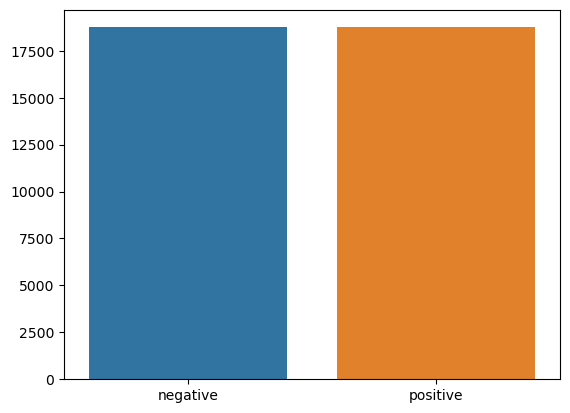

In [4]:
sentiments_train = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=sentiments_train.values)

In [5]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    return s


def tokenize(x_train,y_train,x_val,y_val):
    word_list = []


    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
 
    corpus = Counter(word_list)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])
           
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)
